# 2. Užduotis

Tarkime, kad laikas iki įvykio $T$ turi ekstremalių reikšmių (minimalių) skirstinį, t.y.
pasiskirstymo funkcija

$$
F(t; \mu, \sigma) = 1 - \exp{\{-{e}^{(t - \mu)/\sigma}\}},
$$

Naudodami atvirkštinės transformacijos metodą, sumodeliuokite paprastąją atsitiktinę imtį
(**Pastaba.** Kai iš konteksto aišku, dažnai žodis realizacija praleidžiamas).

In [232]:
library(latex2exp)

set.seed(314)
n <- 100
ts <- runif(n)

In [130]:
inverse_cdf <- function(theta) {
    mu <- theta[1]
    sigma <- theta[2]

    function(t) {
        sigma*log(-log(1 - t)) + mu
    }
}

In [131]:
mu <- 5
sigma <- 10

In [132]:
observ <- inverse_cdf(c(mu, sigma))(ts)

Raskite taškinius ir intervalinius parametrų įverčius.

In [177]:
## Logtikėtinumo funkcija
loglik <- function(observations) {
    function(theta) {
        mu <- theta[1]
        sigma <- theta[2]
        
        sum(-log(sigma)+(observations-mu)/sigma-exp((observations-mu)/sigma))
    }
}

In [192]:
maxlik_optimiser <- function(f, start) {
    suppressPackageStartupMessages(require(maxLik))
    mle <- maxLik::maxLik(logLik = f, start = start)
    r <- list(
        estimates = coef(mle),
        hessian = hessian(mle),
        gradient = gradient(mle)
    )
    return(r)
}

mle_estimator <- function(loglikelihood, optimiser) {
    function(data, start) {
        optimiser(loglikelihood(data), start)
    }
}

Pradiniams artiniams ieškoti naudosimės momentų metodu (parametrą perašysime kaip funkciją nuo vidurkio
ir įstatę imties vidurkį gausime įvertį):

$$
\hat{\mu} = \frac{\pi \bar{x} + \sqrt{6} \gamma \sqrt{s^2}}{\pi}, \hat{\sigma} = \frac{\sqrt{6} \sqrt{s^2}}{\pi}
$$

čia $\bar{x}$ - imties vidurkis, $s^2$ - imties variacija.

In [193]:
moment_estimator <- function(observations) {
    gamma <- 0.5772156

    m <- mean(observations)
    s <- var(observations)

    sigma_hat <- sqrt(6) * sqrt(s) / pi
    mu_hat <- m + gamma * sigma_hat
    
    c(mu_hat, sigma_hat)
}

(start_theta <- moment_estimator(observ))

[1]  3.12191 10.42054

Vertinkime didžiausio tikėtinumo metodu:

In [194]:
(mle <- mle_estimator(loglik, maxlik_optimiser)(observ, start_theta))

-1.0800250,-0.4547474
-0.4547474,-1.9326762


intervaliniams įverčiams rasti naudosime asimptotines DT įvertinių savybes:

In [195]:
mle_asymptotic_ci <- function(mle, sample_size) {
    mle_estimates <- mle$estimates
    fishers_info <- -1 * mle$hessian
    
    # Precalculate:
    fishers_inverse <- solve(fishers_info)
    sqrt_size <- sqrt(sample_size)

    function(confidence) {
        i <- 1
        alpha_half <- (1 - confidence) / 2 

        lapply(mle_estimates, function(e) {
            variance <- fishers_inverse[i, i]
            shift <- sqrt(variance) * qnorm(alpha_half, lower.tail = FALSE) / sqrt_size
            i <- i + 1

            ci <- list(
                lo = e - shift,
                hi = e + shift
            )
                
            return(ci)
        })
    }
}

In [196]:
extreme_minimal_ci <- mle_asymptotic_ci(mle, n)
ci89 <- extreme_minimal_ci(0.89)

In [197]:
mu_hat_mle <- mle$estimates[1]
sigma_hat_mle <- mle$estimates[2]

data.frame(
    name = c("mu", "sigma"),
    actual = c(mu, sigma),
    lo_89 = c(ci89[[1]]$lo, ci89[[2]]$lo),
    ml_estimate = c(mu_hat_mle, sigma_hat_mle),
    hi_89 = c(ci89[[1]]$hi, ci89[[2]]$hi) 
)

name,actual,lo_89,ml_estimate,hi_89
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
mu,5,2.666276,2.828296,2.990315
sigma,10,9.495852,9.657871,9.819891


Pasirinktame taške $t$ įvertinkite pasiskirstymo funkciją ir jos pasikliovimo intervalą.

In [187]:
cdf <- function(theta) {
    mu <- theta[1]
    sigma <- theta[2]
    
    function(t) {
        1 - exp(-exp((t - mu)/sigma))
    }
}

In [228]:
cdf_actual <- cdf(c(mu, sigma))

In [204]:
diff_cdf_mu <- function(theta) {
    mu <- theta[1]
    sigma <- theta[2]

    function (t) {
        -exp(-(mu - t)/sigma - exp(-(mu - t)/sigma))/sigma
    }
}

diff_cdf_sigma <- function(theta) {
    mu <- theta[1]
    sigma <- theta[2]

    function(t) {
        (mu - t)*exp(-(mu - t)/sigma - exp(-(mu - t)/sigma))/sigma^2
    }
}

In [217]:
variance_effective_estimator <- function(mle, sample_size, partials) {
    inverse_hessian <- solve(mle$hessian)

    ## Evaluate partial derivatives of the parameter function, that is, plug-in parameter estimates:
    partials <- sapply(partials, function(p) { p(mle$estimates) })

    function(t) {
        ## Evaluate partial derivatives at t:
        partials_at_t <- sapply(partials, function(p) { p(t) })
        
        as.numeric(-sample_size * (t(partials_at_t) %*% inverse_hessian %*% partials_at_t))
    }
}

In [218]:
var_estim <- variance_effective_estimator(mle, n, c(diff_cdf_mu, diff_cdf_sigma))

In [234]:
asymptotic_ci_estimator <- function(confidence, mle, sample_size, param_f, partials) {
    
    alpha <- 1 - confidence
    critical_value <- qnorm(alpha, mean = 0, sd = 1, lower.tail = FALSE)
    param_f_variance <- variance_effective_estimator(mle, sample_size, partials)
    f <- param_f(mle$estimates)
    
    function(t) {
        mle_at_t <- f(t)
        shift <- sqrt(param_f_variance(t)) * critical_value / sqrt(sample_size)
        lo <- mle_at_t - shift
        hi <- mle_at_t + shift
        
        c(lo = lo, mid = mle_at_t, hi = hi)
    }
}

In [235]:
ci_cdf <- asymptotic_ci_estimator(
    confidence = .89,
    mle = mle,
    sample_size = n,
    param_f = cdf,
    partials = c(diff_cdf_mu, diff_cdf_sigma)
)

In [251]:
qs <- seq(inverse_cdf(c(mu, sigma))(0.01), inverse_cdf(c(mu, sigma))(0.99), length.out = 100)

df_cdf <- data.frame(t(sapply(qs, function(q) {
    
    estim <- unname(ci_cdf(q))
    actual <- cdf_actual(q)
    
    c(
        q = q,
        actual = actual,
        lo = estim[1],
        pointwise = estim[2],
        hi = estim[3]
    )
})))

tail(df_cdf)

,q,actual,lo,pointwise,hi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
95,17.17719,0.9659345,0.9794484,0.9879434,0.9964384
96,17.79611,0.9725459,0.9840684,0.9910002,0.9979320
97,18.41503,0.9781769,0.9878619,0.9934107,0.9989595
98,19.03395,0.9829054,0.9909227,0.9952741,0.9996255
99,19.65287,0.9868165,0.9933461,0.9966843,1.0000224
100,20.27180,0.9900000,0.9952262,0.9977276,1.0002290


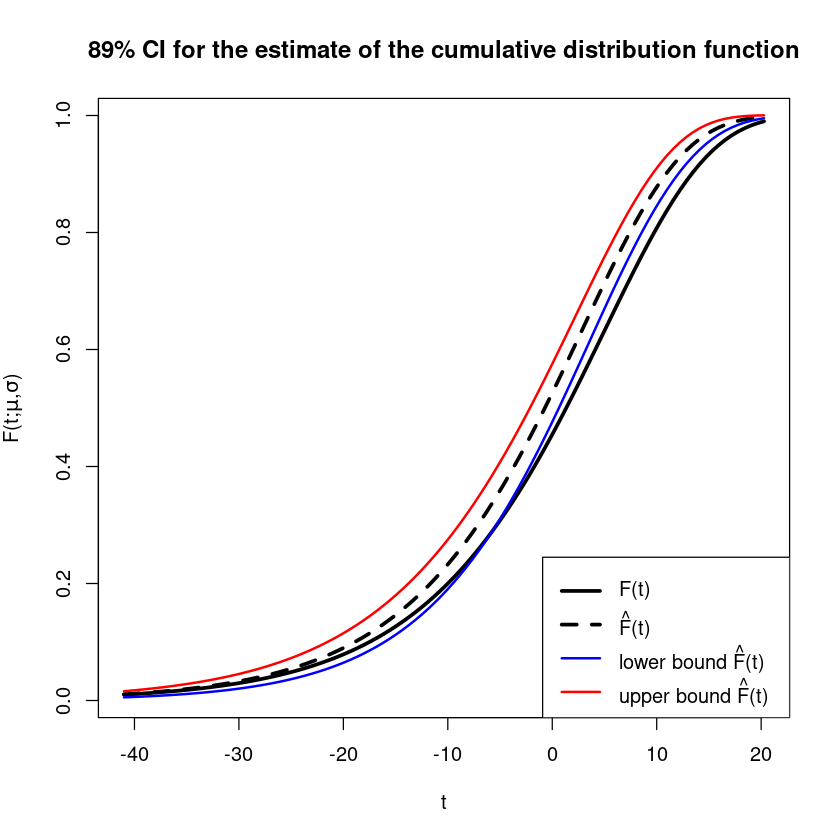

In [252]:
plot(df_cdf$q, df_cdf$actual, col = "black", type = "l", lwd = 3, xlab = "", ylab = "")
lines(df_cdf$q, df_cdf$pointwise, col = "black", lwd = 3, lty = 2)
lines(df_cdf$q, df_cdf$lo, col = "blue", lwd = 2, lty = 1)
lines(df_cdf$q, df_cdf$hi, col = "red", lwd = 2, lty = 1)
title(
    main = "89% CI for the estimate of the cumulative distribution function",
    xlab = "t",
    ylab = TeX("$F(t; \\mu, \\sigma)$")
)
legend(
    "bottomright",
    legend = c(TeX("$F(t)$"), TeX("$\\hat{F}(t)$"), TeX("lower bound $\\hat{F}(t)$"), TeX("upper bound $\\hat{F}(t)$")),
    col = c("black", "black", "blue", "red"),
    lty = c(1, 2, 1, 1),
    lwd = c(3, 3, 2, 2)
)